In [11]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.misc
from scipy import ndimage
import matplotlib.pyplot as plt

import pandas as pd

### Parámetros de Mallado

In [12]:
### RECORREMOS UNA PROFUNDIDAD

dz = 0.01e-6 ## Paso en Profundidad  nm
start_z = 0
stop_z = 0.5e-6

dx = 0.1e-6  ## Paso en Superficie um
start_x = 0e-6
stop_x = 10e-6

### EN UN TIEMPO 
dt = 30e-15  ## Time Step fs
start_t = 0
stop_t = 5e-12 ## Finalizamos a ps


x = np.linspace(start_x,stop_x,int(round((stop_x-start_x)/dx)))
z = np.linspace(start_z,stop_z,int(round((stop_z-start_z)/dz)))
t = np.linspace(start_t,stop_t,int(round((stop_t-start_t)/dt)))

X,Z= np.meshgrid(x,z)

## Auxiliar para X-Z
x_mid = x.shape[0]//2

### Parámetros Generales Red y Láser

In [13]:
# ------------- Red Electrones -----------------
Ce_aux = 134.5 # J / (m^3 K^2)
ke = 235  # J /(m K s)
g = 5.69e17 # J /(m K^3 s)

#  ----------------------------------------------

# ------------- Red Lattice -----------------
Ci = 2.42e6  # J / (m^3 K)
ki = ke/99 # J (m K^3 s) 
#  -------------------------------------------


# ------------- Parámetros Láser -----------------
R = 0.88 # Reflectancia A.U.
delta = 20e-9 # Optical Penetration (nm)
ball_len = 100e-9 # Ballistic Length (nm)
 
tp = 100e-15 # FWHM fs
w0 = 5e-6 # Waist um
wavelength = 1.032e-6 # Wavelength (um)
#  ------------------------------------------------------

# ------------- Parámetros Varios -----------------
ys = 3e-6 ## Perfil de Apertura del Láser (um)
T0 = 300 # K Temperatura Ambiente (K)
x0 = 0 # Posición central del Spot en x
n = 1 ## Refractive Index
Zr = n*np.pi*w0**2/wavelength
w = w0*(1+Z**2/Zr**2)**1/2

In [14]:
Tc = 5370 # Temperatura Crítica (K)
F = 5*1e4 # Fluence J/cm^2 -> J/m^2
N = 5 # NUMERO DE PULSOS

### Valores para primer pulso (Inicialización)

In [15]:
### ZS PARA PRIMER PULSO ES 0
Zs = np.zeros_like(Z)

### LASER POWER PARA PRIMER PULSO
T = 1/tp * np.sqrt(4 * np.log(2)/np.pi) * np.exp(
-4*np.log(2) * ((t - 2*tp)/tp)**2)


S = (1-R)/ (delta + ball_len) * w0**2/w**2 * np.exp(-(Z-Zs)/(delta+ball_len)-4*(X-x0)**2/w**2)

### PARAMETRO AUXILIAR
s = dt/Ce_aux

### TEMPERATURAS INICIALES
Te = np.ones_like(X[:,:])*300
Ti = np.ones_like(X[:,:])*300
Tenew,Tinew = np.zeros_like(Te), np.zeros_like(Ti)

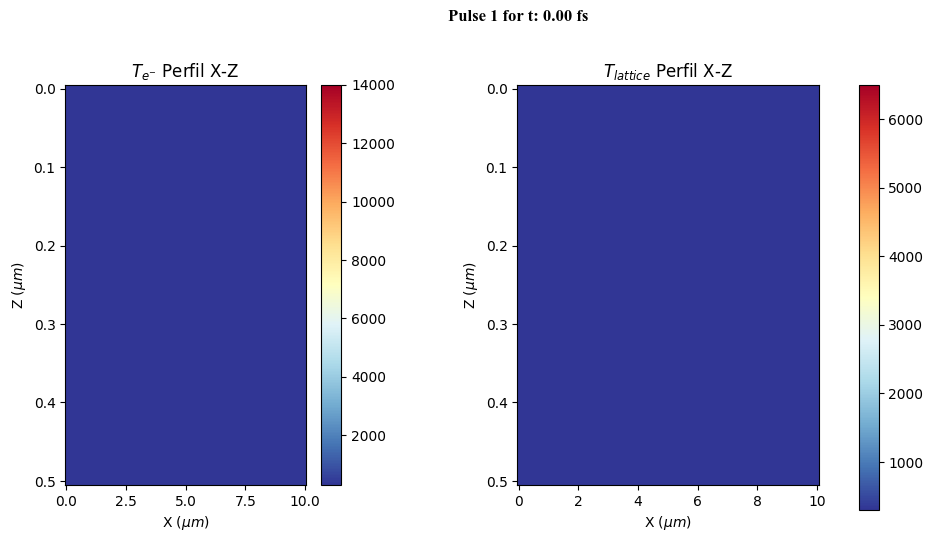

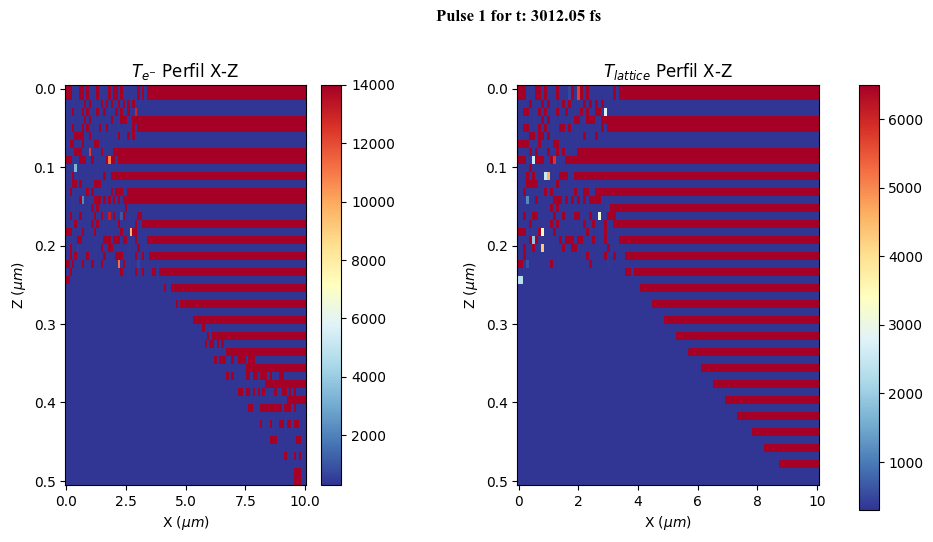

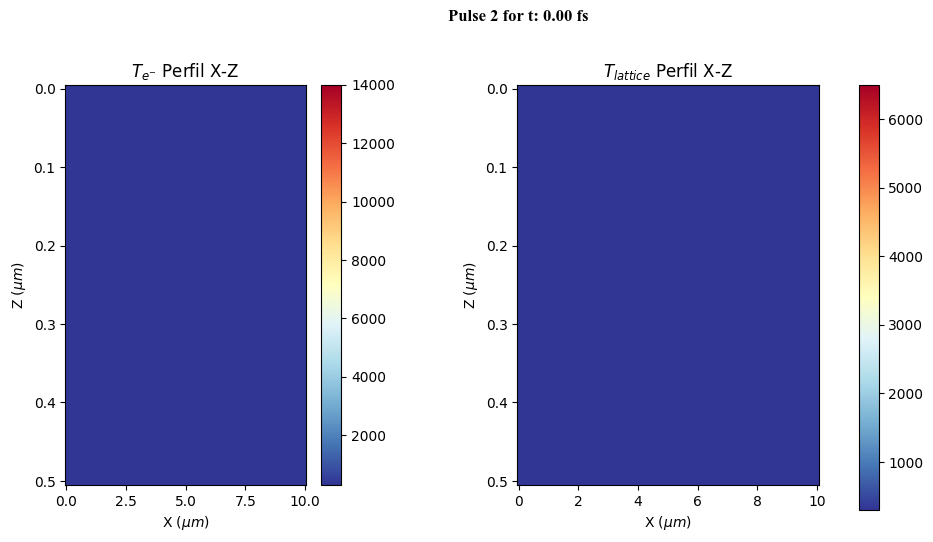

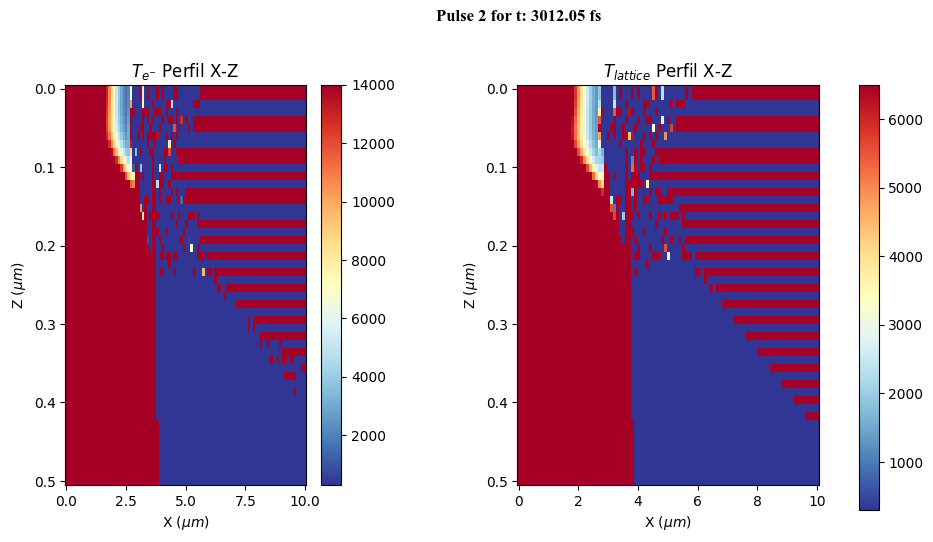

In [16]:
depths_craters = []
diameters_craters = []

for nn in range(N):
    
    for n in range(0,len(t)-1):
        for i in range(1,len(z)-1):
            for k in range(1,len(x)-1):
                Tenew[i,k] = Te[i,k] + s/Te[i,k]*(
                    ke*((Te[i+1,k] - 2 * Te[i,k] + Te[i-1,k])/dz/dz + 2*(Te[i,k+1] -2*Te[i,k] + Te[i,k-1])/dx/dx)) - (
                    s/Te[i,k]*g*(Te[i,k]-Ti[i,k])) + s/Te[i,k]*S[i,k]*T[n]
            
                Tinew[i,k] = Ti[i,k] + dt/Ci*ki*((Ti[i+1,k]-2*Ti[i,k]-Ti[i-1,k])/dz/dz + 2*(Ti[i,k-1]-2*Ti[i,k+1]+Ti[i,k+1])/dx/dx) +dt/Ci * g * (Te[i,k] - Ti[i,k])
            
        ### CONDICIONES DE CONTORNO
        Tenew[0,:], Tenew[-1,:], Tenew[:,0], Tenew[:,-1] = Tenew[1,:], Tenew[-2,:], Tenew[:,1], Tenew[:,-2]
        Tinew[0,:], Tinew[-1,:], Tinew[:,0], Tinew[:,-1] = Tinew[1,:], Tinew[-2,:], Tinew[:,1], Tinew[:,-2]
        Te = Tenew
        Ti = Tinew
    
        if (n%100 == 0):

            fig, ((ax2), (ax4)) = plt.subplots(1,2,figsize=(10,5))
            plt.gca().invert_yaxis()
            fig.tight_layout()

            fig.subplots_adjust(hspace=0.5,wspace=0.5)
            fig.suptitle(f'Pulse {nn+1} for t: {t[n]*1e15:.2f} fs',y = 1.05,fontname="Times New Roman", fontweight="bold")


            # im1 = ax1.pcolor(X[:,:,0,n]*1e6,Y[:,:,0,n]*1e6,Te[:,:,0],vmin = 300,vmax = 14000,cmap="RdYlBu_r",)
            # fig.colorbar(im1)
            # ax1.set_title("$T_{e^{-}}$ Perfil X-Y ")
            # ax1.set_xlabel("X ($\mu m$)")
            # ax1.set_ylabel("Y ($\mu m$)")


            im2 = ax2.pcolor(x*1e6,z*1e6,Te[:,:],vmin = 300,vmax = 14000,cmap="RdYlBu_r",)
            fig.colorbar(im2)
            ax2.invert_yaxis()
            ax2.set_title("$T_{e^{-}}$ Perfil X-Z ")
            ax2.set_xlabel("X ($\mu m$)")
            ax2.set_ylabel("Z ($\mu m$)")

            # im3 = ax3.pcolor(X[:,:,0,n]*1e6,Y[:,:,0,n]*1e6,Ti[:,:,0],vmin = 300,vmax = 6500,cmap="RdYlBu_r",)
            # fig.colorbar(im3)
            # ax3.set_title("$T_{lattice}$ Perfil X-Y ")
            # ax3.set_xlabel("X ($\mu m$)")
            # ax3.set_ylabel("Y ($\mu m$)")

            im4 = ax4.pcolor(x*1e6,z*1e6,Ti[:,:],vmin = 300,vmax = 6500,cmap="RdYlBu_r",)
            # fig.colorbar(im4)
            ax4.set_title("$T_{lattice}$ Perfil X-Z ")
            ax4.set_xlabel("X ($\mu m$)")
            ax4.set_ylabel("Z ($\mu m$)")

            plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
            cax = plt.axes([0.84, 0.05, 0.020, 0.85])
            plt.colorbar(im4,cax=cax)

            # for ax in fig.get_axes():
            #     ax.label_outer()

            plt.show()
    
    ### OBTENEMOS EL NUEVO PERFIL DE ABLACION    
    X_profile = Ti[0,:]
    
    for u in range(len(x)):
        for v in range(len(z)):
            ### CALCULO DE Zs y de Profundidad del Pulso
            if Ti[v,u] < 0.9*Tc:
                z_aux = Z[v,u]
                Zs[:,u] = z_aux
                if u == 0:
                    depths_craters.append(z_aux)
                break
            if Ti[-1,:].all() > 0.9*Tc:
                z_aux = Z[v,u]
                Zs[:,u] = z_aux
                depths_craters.append(zaux)
                break
        ### CALCULO DE DIAMETRO DLE PULSO
        if (X_profile[u] < 0.9*Tc):
            diameters_craters.append(2*x[u])
            break
            
    if (len(depths_craters) < nn+1):
        depths_craters.append("Profundidad de Mallado Superada")
        Te = np.ones_like(Ti[:,:])*300
        Ti = np.ones_like(Ti[:,:])*300
        Tenew,Tinew = np.zeros_like(Te), np.zeros_like(Ti)
        np.save(f"Diameters_{N}_Pulses_{F*1e-4}_Fluence",diameters_craters)
        np.save(f"Depth_{N}_Pulses_{F*1e-4}_Fluence",depths_craters)
        
        break
    
    ### CALCULAMOS EL NUEVO POWER LASER
    S = (1-R)/(delta + ball_len) * F * w0**2/w**2 * np.exp(
    -(Z-Zs)/(delta+ball_len) - (4*(X-x0)**2/w**2))
    
    
    ### NUEVAS TEMPERATURAS PENDIENTES DE SIMULACION PARA 2 microsegundos
    Te = np.ones_like(Ti[:,:])*300
    Ti = np.ones_like(Ti[:,:])*300
    Tenew,Tinew = np.zeros_like(Te), np.zeros_like(Ti)
    
    np.save(f"Diameters_{N}_Pulses_{F*1e-4}_Fluence",diameters_craters)
    np.save(f"Depth_{N}_Pulses_{F*1e-4}_Fluence",depths_craters)